## Preparación del entorno de trabajo

In [1]:
# Importar las librerias y módulos necesarios
import pandas as pd # Manejo de datos numéricos
import geopandas as gpd # Manejo de datos espaciales
import fiona # Lectura de archivos vectoriales
import folium # Creación de mapas interactivos
import branca.colormap as cm # Creación de mapas de colores
from sklearn.cluster import KMeans # Uso del algoritmo de clasificación K-means
from sklearn.metrics import silhouette_score, davies_bouldin_score # Optimización de modelos
import numpy as np # Cálculo del número óptimo de grupos
import matplotlib.pyplot as plt # Creación de gráficos
from itertools import combinations # Creación de todas las combinaciónes de variables

In [2]:
# Habilitar la lectura de archivos KML
fiona.drvsupport.supported_drivers['KML'] = 'rw'

## Selección de la información de interés de las colonias cercanas

In [3]:
# Lectura de los datos de interés de las colonias cercanas a la oficina de TECHO
df = pd.read_csv('/content/drive/MyDrive/TECHO/InformacionCenso2020/ColoniasCercanasCenso2020.csv', index_col=0)

# Lectura de los datos espaciales de las colonias cercanas a la oficina en Jalisco
gdf = gpd.read_file('/content/drive/MyDrive/TECHO/censo-poblacion-vivienda-2020-inegi-informacion-demografica-y-social-colonias-estado-jalisco.kml')

# Unión de los datos de las colonias cercanas a la oficina en Jalisco
colonias = gpd.GeoDataFrame(pd.merge(df, gdf.iloc[:, -1], left_index=True, right_index=True))

## Creación de la capa 'Oficina'

In [4]:
# Ubicación y distancia aceptable a la oficina de TECHO
oficina = [20.7009, -103.3676]
distancia = 20000 # 20 km

In [5]:
# Crear una capa con información respecto a la oficina de TECHO
capa_oficina = folium.FeatureGroup(name='Oficina')
folium.Circle(location=oficina, radius=distancia, color='black', weight=0.5).add_to(capa_oficina)
folium.Circle(location=oficina, radius=distancia/2, color='black', weight=0.5).add_to(capa_oficina)
folium.Circle(location=oficina, radius=10, color='black', fill=True, fill_opacity=1).add_to(capa_oficina)

## Creación de la capa 'No censadas'

In [6]:
# Identificar los datos de las colonias no censadas
colonias_no_censadas = colonias[(colonias == 'ND2020').any(axis=1)]

# Crear una capa para la información de las colonias no censadas
capa_no_censadas = folium.FeatureGroup(name=f'No censadas ({colonias_no_censadas.shape[0]})')

# Añadir información de las colonias no censadas
folium.GeoJson(
    colonias_no_censadas,
    style_function = lambda _: {'color': 'gray', 'fillOpacity': 0.5, 'weight': 0.1},
    tooltip = folium.GeoJsonTooltip(fields=colonias.columns[0:2].tolist())
).add_to(capa_no_censadas)

In [7]:
# Conteo del número de municipios dentro del conjunto de datos
municipios = colonias.iloc[:, 1].unique().tolist()

## Cálculo del número óptimo de grupos [K-Means]

In [8]:
# Eliminar la información de las colonias no censadas
colonias = colonias[~(colonias == 'ND2020').any(axis=1)]

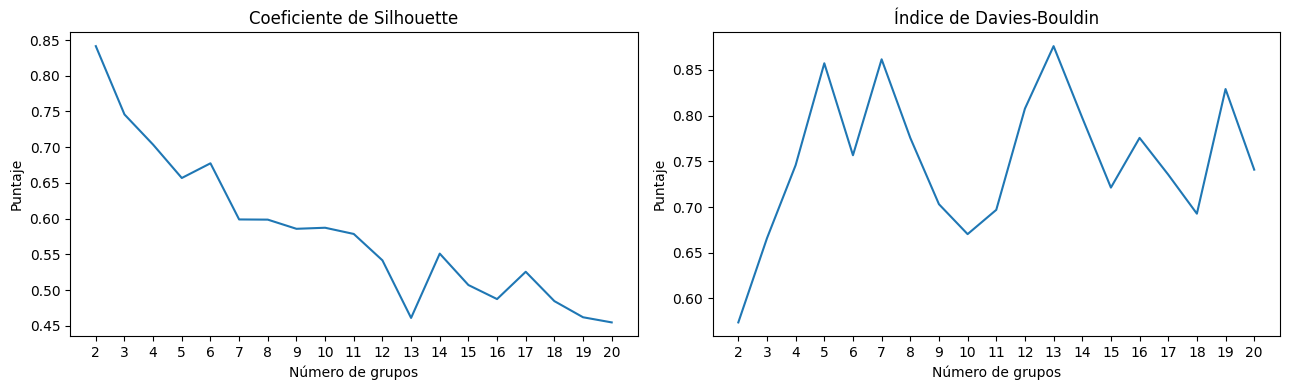

In [9]:
# Listas para guardar los puntajes de cada evaluación
puntaje_s = []
puntaje_db = []

# Identificar las series pertinentes
datos = colonias.iloc[:, 2:-1].copy().values

# Rango de valores propuestos para el número de grupos
ns = list(range(2, 21))

# Por cada número de grupos propuesto
for n in ns:

  # Generar un modelo K-Means con el número de grupos propuesto
  modelo = KMeans(n_clusters=n, n_init='auto').fit(datos)

  # Calcular el coeficiente de Silhouette y añadir al arreglo correspondiente
  puntaje_s.append(silhouette_score(datos, modelo.labels_))

  # Calcular el índice de Davies-Bouldin y añadir al arreglo correspondiente
  puntaje_db.append(davies_bouldin_score(datos, modelo.labels_))

# Calcular el número óptimo de grupos
n_optimo = np.argmax(np.array(puntaje_s) - np.array(puntaje_db))+2

# Crear una figura para graficar los resultados de cada combinación
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

# Generar el gráfico del coeficiente de Silhouette
axs[0].plot(ns, puntaje_s)
axs[0].set_xlabel('Número de grupos')
axs[0].set_ylabel('Puntaje')
axs[0].set_title('Coeficiente de Silhouette')
axs[0].set_xticks(ns)

# Generar el gráfico del índice de Davies-Bouldin
axs[1].plot(ns, puntaje_db)
axs[1].set_xlabel('Número de grupos')
axs[1].set_ylabel('Puntaje')
axs[1].set_title('Índice de Davies-Bouldin')
axs[1].set_xticks(ns)

# Configurar el diseño de la figura
plt.tight_layout()

# Guardar los gráficos generados
plt.savefig('/content/drive/MyDrive/TECHO/AgrupamientoCenso2020/OptimizacionK-Means.png')

# Mostrar los gráficos generados
plt.show()

## Creación de un modelo optimizado [K-Means]


In [10]:
# Crear y entrenar un modelo K-Means optimizado
modelo = KMeans(n_clusters=n_optimo, n_init='auto').fit(datos)

# Almacenar las etiquetas del modelo entrenado
etiquetas = pd.Series(modelo.labels_)

# Almacenar los centros de cada grupo generado por el modelo
centros = modelo.cluster_centers_

In [11]:
# Identificar el grupo con datos atípicos
grupo_atipicos = etiquetas.value_counts().idxmin()

# Identificar los índices de los datos atípicos
indice_atipicos = etiquetas[etiquetas == grupo_atipicos].index.tolist()

<ipython-input-12-a1c28e921305>:46: UserWarning: Glyph 135 (\x87) missing from current font.
  plt.tight_layout()
<ipython-input-12-a1c28e921305>:49: UserWarning: Glyph 135 (\x87) missing from current font.
  plt.savefig('/content/drive/MyDrive/TECHO/AgrupamientoCenso2020/VisualizacionK-Means.png')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 135 (\x87) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


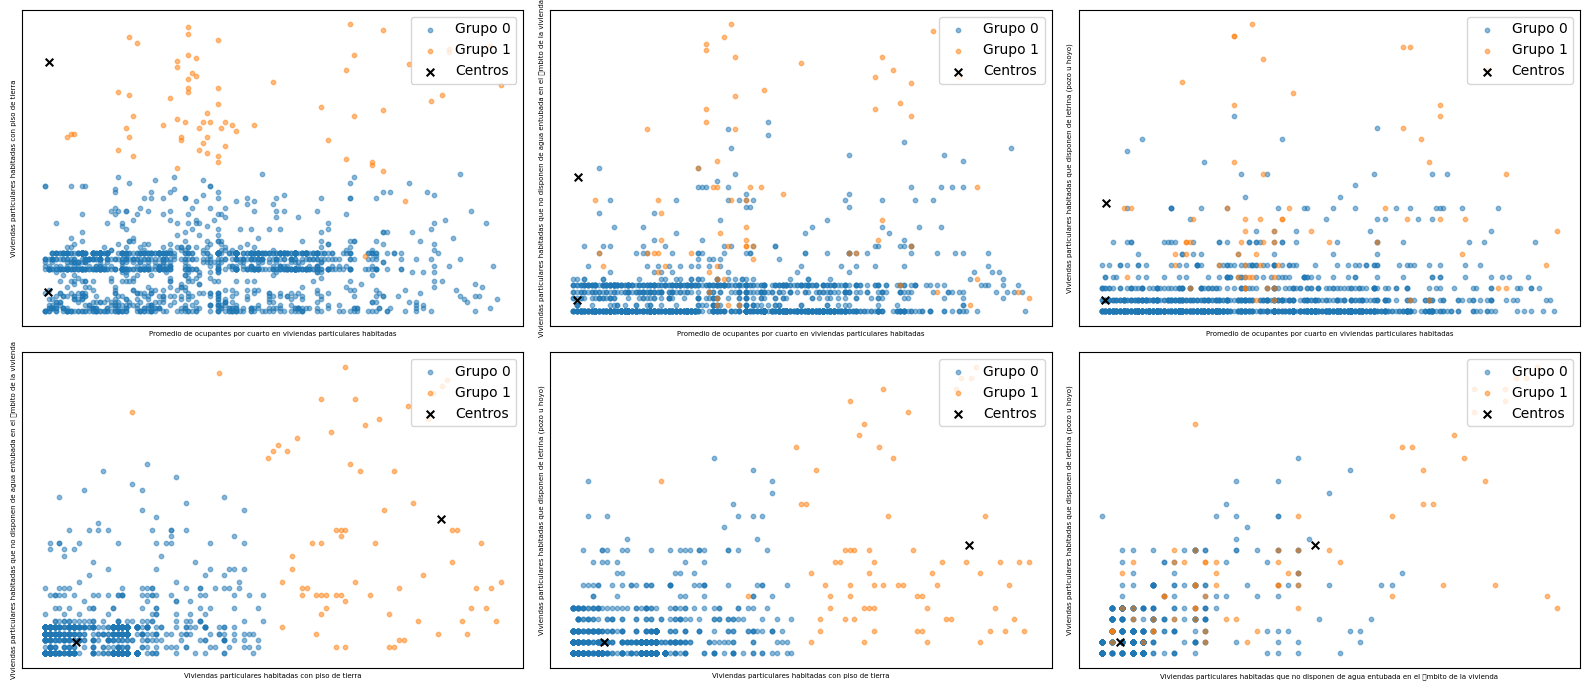

In [12]:
# Crear todas las combinaciones posibles de series
combinaciones = list(combinations(colonias.columns[2:-1], 2))

# Identificar el número de series utilizadas para el entrenamiento del modelo
columnas = (len(combinaciones)+1)//2

# Crear una figura para graficar los resultados de cada combinación
fig, axs = plt.subplots(2, columnas, figsize=(16, 7))

# Por cada combinación
for i in range(len(combinaciones)):

  # Identificar el gráfico correspondiente
  fila = i // columnas
  col = i % columnas

  # Identificar las series correspondientes
  c1 = combinaciones[i][0]
  c2 = combinaciones[i][1]

  # Lista para guardar las coordenadas de los centros
  cs = []

  # Por cada centro
  for c in range(len(centros)):

    # Graficar los datos del grupo
    datos = colonias.iloc[etiquetas.index[etiquetas==c]]
    axs[fila, col].scatter(datos[c1].values, datos[c2].values, s=10, alpha=0.5, label=f'Grupo {c}')

    # Calcular las coordenadas del centro y añadir al arreglo correspondiente
    centro = centros[c]
    cs.append([centro[colonias.columns.get_loc(c1)-2], centro[colonias.columns.get_loc(c2)-2]])

  # Graficar todos los centros
  axs[fila, col].scatter(np.array(cs)[:, 0], np.array(cs)[:, 1], marker='x', s=30, color='black', label='Centros')

  # Configurar el diseño del gráfico
  axs[fila, col].set_xlabel(combinaciones[i][0], fontsize=5)
  axs[fila, col].set_ylabel(combinaciones[i][1], fontsize=5)
  axs[fila,col].legend(loc='upper right')
  axs[fila, col].set_xticks([])
  axs[fila, col].set_yticks([])

# Configurar el diseño de la figura
plt.tight_layout()

# Guardar los gráficos generados
plt.savefig('/content/drive/MyDrive/TECHO/AgrupamientoCenso2020/VisualizacionK-Means.png')

# Mostrar los gráficos generados
plt.show()

## Creación de las capas generadas por el modelo

In [13]:
# Identificar los datos atípicos
colonias_atipicas = colonias.iloc[indice_atipicos]

# Conteo del número de municipios dentro del conjunto de datos
municipios_atipicos = colonias_atipicas.iloc[:, 1].unique().tolist()

# Creación de un mapa de colores acorde al número de municipios
colores = cm.linear.Spectral_04.scale(0, len(municipios_atipicos)).to_step(len(municipios_atipicos))

# Visualizar el mapa de colores
display(colores)

In [14]:
# Lista para guardar las capas
capas_municipios = []

# Por cada municipio
for municipio in municipios_atipicos:

  # Identificar los datos de cada municipio
  datos = colonias_atipicas[colonias_atipicas.iloc[:, 1]==municipio]

  # Crear una capa con los datos del municipio
  capa = folium.GeoJson(
      datos[datos.iloc[:, 1]==municipio],
      name = f'{municipio} ({datos.shape[0]})',
      style_function = lambda feature: {'fillColor': colores(municipios_atipicos.index(feature['properties'][datos.columns[1]])), 'fillOpacity': 0.5, 'color': 'gray', 'weight': 0.1},
      tooltip = folium.GeoJsonTooltip(fields=datos.columns[:-1].tolist()))

  # Añadir la capa a la lista
  capas_municipios.append(capa)

## Combinar todas las capas en un mapa

In [15]:
# Crear un mapa centrado en la oficina de TECHO
mapa = folium.Map(location=oficina, zoom_start=11, tiles='cartodbpositron')

# Añadir la capas 'Oficina' y 'No censadas'
capa_oficina.add_to(mapa)
capa_no_censadas.add_to(mapa)

# Por cada capa con información de un municipio
for capa in capas_municipios:
  capa.add_to(mapa) # Añadir la capa al mapa

# Añadir un controlador de capas
folium.LayerControl().add_to(mapa)

# Guardar el mapa como archivo HTML
mapa.save('/content/drive/MyDrive/TECHO/AgrupamientoCenso2020/ColoniasPrioritariasCenso2020.html')

# Visualizar el mapa
mapa

# Creación de un archivo XLSX con la información de los municipios

In [16]:
# Seleccionar el índice de la serie de mayor interés
s = 3

# Cambiar el tipo de dato de las series numéricas
colonias_atipicas[colonias_atipicas.columns[2:-1]] = colonias_atipicas[colonias_atipicas.columns[2:-1]].apply(pd.to_numeric)

# Exportar la información de cada municipio a un archivo XLSX
with pd.ExcelWriter('/content/drive/MyDrive/TECHO/AgrupamientoCenso2020/ColoniasPrioritariasCenso2020.xlsx') as writer:

  # Por cada municipio cercano
  for municipio in municipios:

    # Identificar los datos de las colonias atípicas y no censadas
    c_a = colonias_atipicas[colonias_atipicas.iloc[:, 1]==municipio].drop(columns=colonias_atipicas.columns[1])
    c_n_c = colonias_no_censadas[colonias_no_censadas.iloc[:, 1]==municipio].iloc[:,:1]

    # Combinar la información de ambos tipos de colonias
    c_c = pd.concat([c_a, c_n_c]).iloc[:, :-1].sort_values(by=[c_a.columns[s-1]], ascending=False)

    # Escribir la información combinada de las colonias en la hoja correspondiente
    c_c.to_excel(writer, sheet_name=municipio, index=False)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
